# AI FOR SECURITY - PROJECT 2024/2025

## INTRODUCTION

The Internet of Medical Things (IoMT) has become increasingly vital in healthcare, enabling continuous patient monitoring and automated medical services. However, this connectivity also introduces cybersecurity risks that could compromise patient care and privacy. The CICIoMT2024 dataset, developed by the Canadian Institute for Cybersecurity (CIC), provides a comprehensive benchmark for evaluating IoMT security solutions.

### Dataset Overview
- Contains network traffic from 40 IoMT devices (25 real and 15 simulated)
- Includes traffic across multiple protocols: Wi-Fi, MQTT, and Bluetooth
- Features 18 different types of attacks categorized into:
  - DDoS (Distributed Denial of Service)
  - DoS (Denial of Service)
  - Reconnaissance
  - MQTT-specific attacks
  - Spoofing


### Project Objectives
1. Analyze a subset of the CICIoMT2024 dataset to develop efficient security models
2. Implement and evaluate both supervised and unsupervised learning approaches
3. Compare model performance across different attack categories
4. Identify the most effective model for real-time threat detection in IoMT networks

Our analysis will focus on the trade-off between model complexity and detection accuracy, aiming to provide practical insights for securing healthcare IoT infrastructure.

## LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate
from tqdm import tqdm
from rich import print
from rich.tree import Tree
from rich.panel import Panel
from rich.console import Console
from rich.table import Table
import re
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import os
import shutil
from typing import Tuple, Dict, Literal, Optional, List
from collections import defaultdict

from joblib import dump, load
import json

### Data Manipulation and Analysis

In [ ]:
import pandas as pd
import numpy as np

### Data Visualisation

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate
from tqdm import tqdm
from rich import print
from rich.tree import Tree
from rich.panel import Panel

### Text Processing

In [8]:
import re

### Machine Learning

In [7]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

### Evaluation

In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

### System/File Operations

In [2]:
import os
import shutil
from typing import Tuple, Dict, Literal, Optional, List
from collections import defaultdict

## DATASET PREPARATION

### Download Dataset

Create the directory and download the whole CSV dataset through *wget*
```bash
mkdir dataset
cd dataset/ && wget -c -r -np -nH --cut-dirs=3 -R "index.html*" http://205.174.165.80/IOTDataset/CICIoMT2024/Dataset/WiFI_and_MQTT/attacks/CSV/
```

### Analyse Dataset

The dataset consists of network traffic files organized by protocols and different attack types. Due to the diverse distribution of data across files, the first step consisted in analyzing the volume of samples. This initial assessment was crucial as significant imbalances in data volume between attack types or protocols could skew our analysis.

Understanding distributions allowed us to create a balanced and representative subset of data for our analysis while ensuring computational efficiency.


In this phase, we want to explore the directory and provide a detailed analysis of its structure and contents. It is important to remark that files are named based on the protocol and the attack type; in some cases there are multiple files concerning the same protocol and attack type, for this reason they have been numerated starting from zero.  In order to avoid unbalance in data sampling, the following code allows us to group files based on unique base names. In this way, we obtain 19 files, 18 of which about attacks and 1 about benign data. 
 


In [3]:
def get_size(start_path: str) -> int:
    return sum(os.path.getsize(os.path.join(dirpath, f))
              for dirpath, _, filenames in os.walk(start_path)
              for f in filenames)

def explore_subdirectory(path: str, level: int = 0) -> Dict:
    contents = os.listdir(path)
    dirs = [d for d in contents if os.path.isdir(os.path.join(path, d))]
    files = [f for f in contents if os.path.isfile(os.path.join(path, f))]
    
    stats = {
        'directory': os.path.basename(path),
        'num_dirs': len(dirs),
        'num_files': len(files),
        'size_mb': get_size(path) / (1024 * 1024),
        'unique_bases': len(set(re.sub(r'\d+', '', f) for f in files))
    }
    
    tree = Tree(f"📁 {stats['directory']}")
    tree.add(f"Directories: {stats['num_dirs']}")
    tree.add(f"Files: {stats['num_files']}")
    tree.add(f"Size: {stats['size_mb']:.2f} MB")
    tree.add(f"Unique base names: {stats['unique_bases']}")
    
    print(Panel(tree, border_style="black"))
    
    for subdir in dirs:
        explore_subdirectory(os.path.join(path, subdir), level + 1)
        
    return stats

In [8]:
_ = explore_subdirectory('dataset/original')

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ 📁 original                                                                                                     │
│ ├── Directories: 2                                                                                              │
│ ├── Files: 0                                                                                                    │
│ ├── Size: 2171.92 MB                                                                                            │
│ └── Unique base names: 0                                                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ 📁 test_og                                                                                                      │
│ ├── Directories: 0                                                                                              │
│ ├── Files: 21                                                                                                   │
│ ├── Size: 393.78 MB                                                                                             │
│ └── Unique base names: 19                                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ 📁 train_og                                                                                                     │
│ ├── Directories: 0                                                                                              │
│ ├── Files: 51                                                                                                   │
│ ├── Size: 1778.14 MB                                                                                            │
│ └── Unique base names: 19                                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Through the previous statistics, it is possible to merge CSV files, based on their base names, within specified directories, respectively 'train_og' for training and 'test_og' for testing data. The code below allows for identifying all CSV files in the directory and grouping them by their base names. For each group containing more than one file, the function reads the files, concatenates them into a single DataFrame by merging their contents row-wise, and saves the resulting file back into the directory using the base name.


In [4]:
def merge_files_by_base_name(directory: str) -> None:
    in_dir = os.path.join('dataset/original', directory + '_og')
    out_dir = os.path.join('dataset/merged', directory)
    
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)

    # Get all files in the directory
    files = [f for f in os.listdir(in_dir) if f.endswith('.csv')]
    
    # Group files by base name (excluding trailing numbers)
    grouped_files = defaultdict(list)
    for file in files:
        base_name = re.sub(r'\d+', '', file)
        grouped_files[base_name].append(file)
    
    # Merge files in each group
    for base_name, file_list in grouped_files.items():
        dfs = []
        if len(file_list) <= 1:
            src_file = os.path.join(in_dir, file_list[0])
            dest_file = os.path.join(out_dir, f"{base_name}")
            shutil.copy(src_file, dest_file)
            continue

        for file in file_list:
            file_path = os.path.join(in_dir, file)
            df = pd.read_csv(file_path)
            dfs.append(df)
        
        # Concatenate all dataframes in the group
        merged_df = pd.concat(dfs, ignore_index=True)
        
        # Save the merged dataframe
        output_file = os.path.join(out_dir, f"{base_name}")
        merged_df.to_csv(output_file, index=False)

In [ ]:
merge_files_by_base_name('train')
merge_files_by_base_name('test')

In [8]:
_ = explore_subdirectory('dataset/merged')

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ 📁 merged                                                                                                       │
│ ├── Directories: 2                                                                                              │
│ ├── Files: 0                                                                                                    │
│ ├── Size: 2171.90 MB                                                                                            │
│ └── Unique base names: 0                                                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ 📁 train                                                                                                        │
│ ├── Directories: 0                                                                                              │
│ ├── Files: 19                                                                                                   │
│ ├── Size: 1778.12 MB                                                                                            │
│ └── Unique base names: 19                                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ 📁 test                                                                                                         │
│ ├── Directories: 0                                                                                              │
│ ├── Files: 19                                                                                                   │
│ ├── Size: 393.78 MB                                                                                             │
│ └── Unique base names: 19                                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

#### File Length Analysis

The following code analyzes and visualizes data distribution across files, implementing a sampling process based on file sizes:
- Files < 20k rows or benign files: retained entirely
- Files 20K - 100K rows: keep 20ks rows + 20% of remaining data
- Files > 100K rows: applay previus rules + 10% of remaining data

This stratified sampling approach helps maintain dataset balance while managing computational resources. The visualization uses color coding (green/orange/red) to highlight size thresholds.


In [11]:
PLOT_CONFIG = {
    'thresholds': {'small': 20000, 'medium': 100000},
    'colors': {'small': 'green', 'medium': 'orange', 'large': 'red'},
    'base_path': 'dataset'
}

def get_color_by_length(length: int) -> str:
    if length < PLOT_CONFIG['thresholds']['small']:
        return PLOT_CONFIG['colors']['small']
    elif length < PLOT_CONFIG['thresholds']['medium']:
        return PLOT_CONFIG['colors']['medium']
    return PLOT_CONFIG['colors']['large']

def get_directory_path(name: str, directory_type: Literal['original', 'subset']) -> str:
    return os.path.join(PLOT_CONFIG['base_path'], directory_type, f"{name}")

def get_file_lengths(data_dir: str) -> Dict[str, int]:
    return {
        file: len(pd.read_csv(os.path.join(data_dir, file)))
        for file in os.listdir(data_dir)
        if file.endswith('.csv') and not re.search(r'\d', file)
    }

In [14]:
def plot_len(
    name: str,
    directory_type: Literal['merged', 'subset'] = 'merged',
    sort_by: Literal['name', 'length'] = 'length',
    ascending: bool = True
) -> None:
    # Get data
    data_dir = get_directory_path(name, directory_type)
    if not os.path.exists(data_dir):
        print(f"Directory not found: {data_dir}")
        return
        
    file_lengths = get_file_lengths(data_dir)
    if not file_lengths:
        print(f"No CSV files found in {data_dir}")
        return

    # Sort data
    sorted_items = sorted(
        file_lengths.items(),
        key=lambda x: x[0] if sort_by == 'name' else x[1],
        reverse=not ascending
    )
    files, lengths = zip(*sorted_items)

    # Create and style plot
    plt.figure(figsize=(15, 8))
    bars = plt.bar(files, lengths)

    if directory_type == "merged":
        for bar in bars:
            bar.set_color(get_color_by_length(bar.get_height()))
        
        legend_elements = [
            plt.Rectangle((0,0), 1, 1, facecolor=color, label=f'{label} rows')
            for label, color in [('<20k', 'green'), ('20k-100k', 'orange'), ('>100k', 'red')]
        ]
        plt.legend(handles=legend_elements)

    plt.title(f'Number of Rows in Each CSV File - {name} Dataset ({directory_type})', pad=20)
    plt.xlabel('File Names')
    plt.ylabel('Number of Rows')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    # Save and display
    os.makedirs('img', exist_ok=True)
    plt.savefig(f'img/file_lengths_{name}_{directory_type}.png', bbox_inches='tight')
    plt.show()

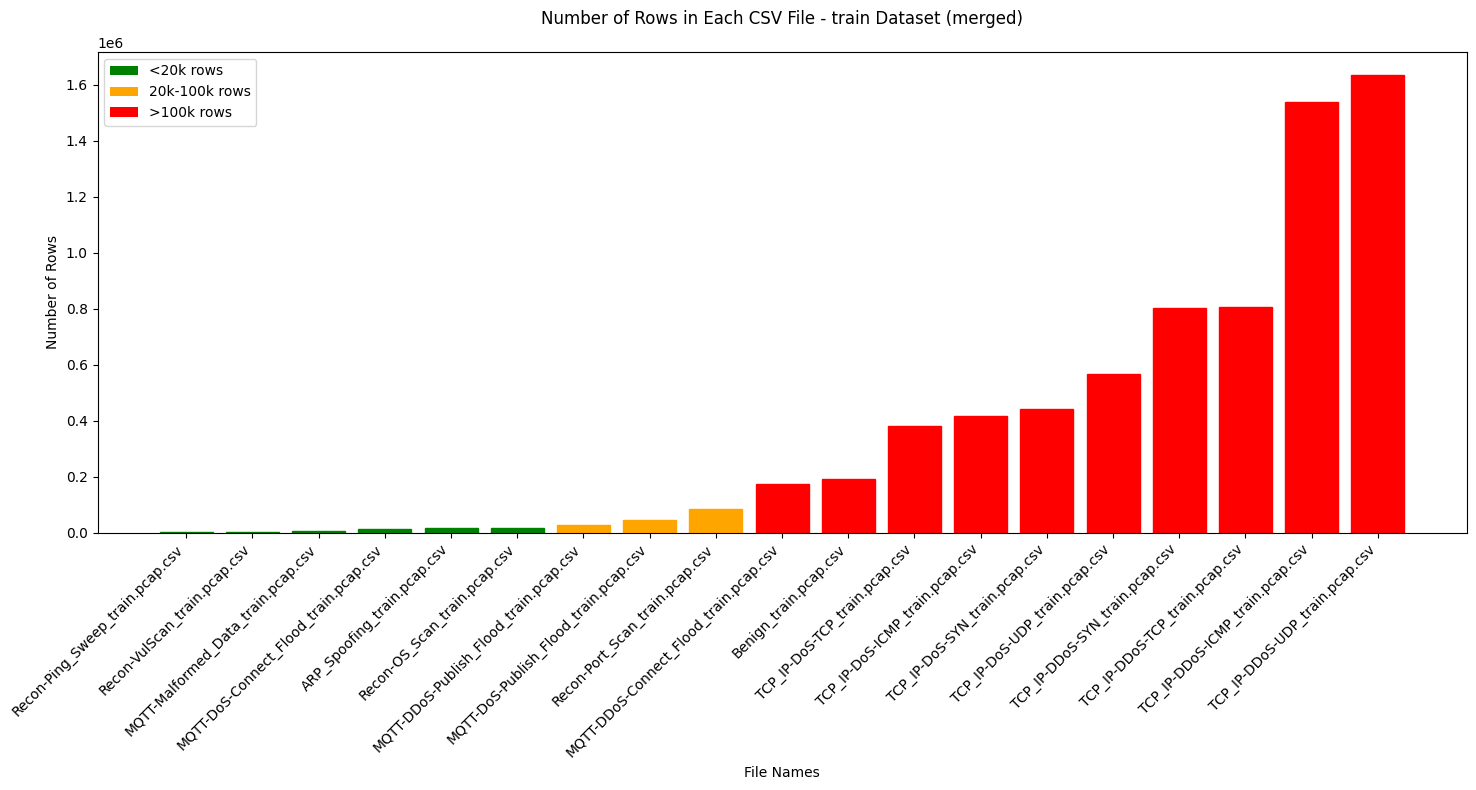

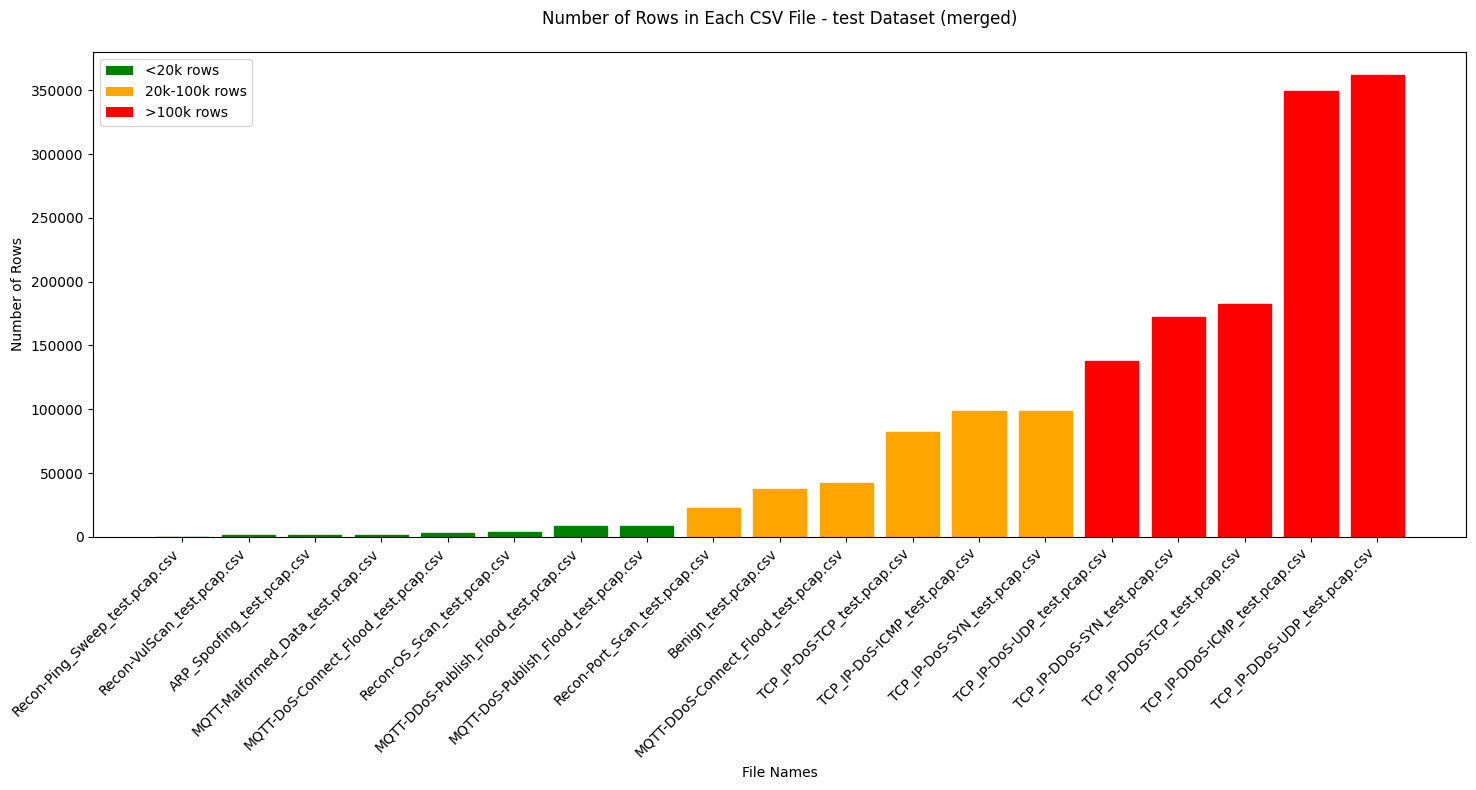

In [15]:
plot_len('train')
plot_len('test')

### Subset

#### Create Directory
```bash
mkdir dataset/subset && cd dataset/subset
mkdir train && mkdir test
```

#### Subset Generation 

This code implements our sampling strategy through random sampling, using a fixed random seed for reproducibility. 

For each file, it applies the rules presented before.
The stratified approach maintains data representativeness while reducing volume, with random sampling ensuring unbiased selection across each range.

In [56]:
SUB_CONFIG = {
    'RANDOM_SEED': 42,
    'CAP': 20000,
    'FIRST': 0.2,
    'SECOND': 0.1,
    'DIRS': {
        'original': 'dataset/merged',
        'subset': 'dataset/subset'
    }
}

def calculate_subset(df: pd.DataFrame) -> pd.DataFrame:
    """Create subset based on dataframe size."""
    total_rows = len(df)
    
    if total_rows < SUB_CONFIG['CAP']:
        return df
        
    # Get first 20k random rows
    first = df.sample(n=SUB_CONFIG['CAP'], random_state=SUB_CONFIG['RANDOM_SEED'])
    
    if total_rows < 100000:
        # For files between 20k and 100k
        remaining = df.drop(first.index)
        additional = remaining.sample(frac=SUB_CONFIG['FIRST'], 
                                   random_state=SUB_CONFIG['RANDOM_SEED'])
        return pd.concat([first, additional])
    
    # For files over 100k
    next_80k = df.drop(first.index).sample(
        n=(100000-SUB_CONFIG['CAP']), 
        random_state=SUB_CONFIG['RANDOM_SEED']
    )
    twenty_percent = next_80k.sample(
        frac=0.2, 
        random_state=SUB_CONFIG['RANDOM_SEED']
    )
    
    remaining = df.drop(first.index).drop(next_80k.index)
    ten_percent = remaining.sample(
        frac=0.1, 
        random_state=SUB_CONFIG['RANDOM_SEED']
    )
    
    return pd.concat([first, twenty_percent, ten_percent])

In [63]:
def process_file(file_path: str, output_path: str) -> tuple:
    """Process single file and return statistics."""
    df = pd.read_csv(file_path)
    original_size = len(df)
    
    if 'Benign' in file_path:
        df_subset = df.copy()
    else:
        df_subset = calculate_subset(df)
    
    df_subset.to_csv(output_path, index=False)
    
    return original_size, len(df_subset)

def create_subset(name: str) -> None:
    """Create subset for given dataset."""
    np.random.seed(SUB_CONFIG['RANDOM_SEED'])
    
    # Setup directories
    og_dir = os.path.join(SUB_CONFIG['DIRS']['original'], f"{name}")
    sub_dir = os.path.join(SUB_CONFIG['DIRS']['subset'], name)
    os.makedirs(sub_dir, exist_ok=True)
    
    print(f"Processing directory: {og_dir}")
    
    total_orig_size = 0
    total_sub_size = 0
    
    # Process files
    for file in os.listdir(og_dir):
        if file.endswith('.csv') and not re.search(r'\d', file):
            orig_size, sub_size = process_file(
                os.path.join(og_dir, file),
                os.path.join(sub_dir, file)
            )
            
            total_orig_size += orig_size
            total_sub_size += sub_size
            
    
    overall_reduction = ((total_orig_size - total_sub_size) / total_orig_size * 100)
    print(f"\nOverall reduction: {total_orig_size} -> {total_sub_size} ({overall_reduction:.2f}% reduction)")

In [64]:
create_subset('train')
create_subset('test')

Processing directory: dataset/merged/train

Overall reduction: 7160831 -> 1235465 (82.75% reduction)

Processing directory: dataset/merged/test

Overall reduction: 1614182 -> 465367 (71.17% reduction)

In [65]:
def plot_comparison(name: str) -> None:
    # Get data for both directories
    original_dir = get_directory_path(name, 'merged')
    subset_dir = get_directory_path(name, 'subset')
    
    if not all(os.path.exists(d) for d in [original_dir, subset_dir]):
        print(f"One or both directories not found: {original_dir}, {subset_dir}")
        return
        
    # Get lengths for both datasets
    original_lengths = get_file_lengths(original_dir)
    subset_lengths = get_file_lengths(subset_dir)
    
    if not all([original_lengths, subset_lengths]):
        print("No CSV files found in one or both directories")
        return
        
    # Sort data by length
    orig_items = sorted(original_lengths.items(), key=lambda x: x[1])
    subset_items = sorted(subset_lengths.items(), key=lambda x: x[1])
    
    orig_files, orig_lengths = zip(*orig_items)
    subset_files, subset_lengths = zip(*subset_items)
    
     # Create figure with adjusted size (less height needed without labels)
    fig, ax1 = plt.subplots(figsize=(20, 8))
    ax2 = ax1.twinx()
    
    # Plot original dataset first (background)
    bars1 = ax1.bar(range(len(orig_files)), orig_lengths, 
                    label='Original Dataset', alpha=0.7,
                    color=[get_color_by_length(l) for l in orig_lengths],
                    zorder=1)
    
    # Plot subset dataset second (foreground)
    bars2 = ax2.bar(range(len(subset_files)), subset_lengths, 
                    label='Processed Dataset', alpha=0.5, edgecolor='black',
                    color=[get_color_by_length(l) for l in subset_lengths],
                    zorder=2)
    
    # Customize axes
    ax1.set_ylabel('Number of Rows (Original)', color='darkblue', fontsize=12)
    ax2.set_ylabel('Number of Rows (Processed)', color='darkred', fontsize=12)
    
    # Remove x-axis labels completely
    ax1.set_xticks([])  # Remove x-ticks
    ax1.set_xticklabels([])  # Remove x-tick labels
    
    # Add legends
    color_legend = [
        plt.Rectangle((0,0), 1, 1, facecolor=color, alpha=0.7, label=f'{label} rows')
        for label, color in [('<20k', 'green'), ('20k-100k', 'orange'), ('>100k', 'red')]
    ]
    dataset_legend = [
        plt.Rectangle((0,0), 1, 1, facecolor='gray', alpha=0.7, label='Original'),
        plt.Rectangle((0,0), 1, 1, facecolor='gray', alpha=0.5, label='Processed')
    ]
    
    # Position legend
    ax1.legend(handles=color_legend + dataset_legend, 
              loc='upper left')
    
    # Add title
    plt.title(f'Comparison of Row Counts - {name} Dataset', 
             pad=20, 
             fontsize=14)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save
    plt.savefig(f'img/file_lengths_comparison_{name}.png', 
                bbox_inches='tight',
                dpi=300)
    plt.show()

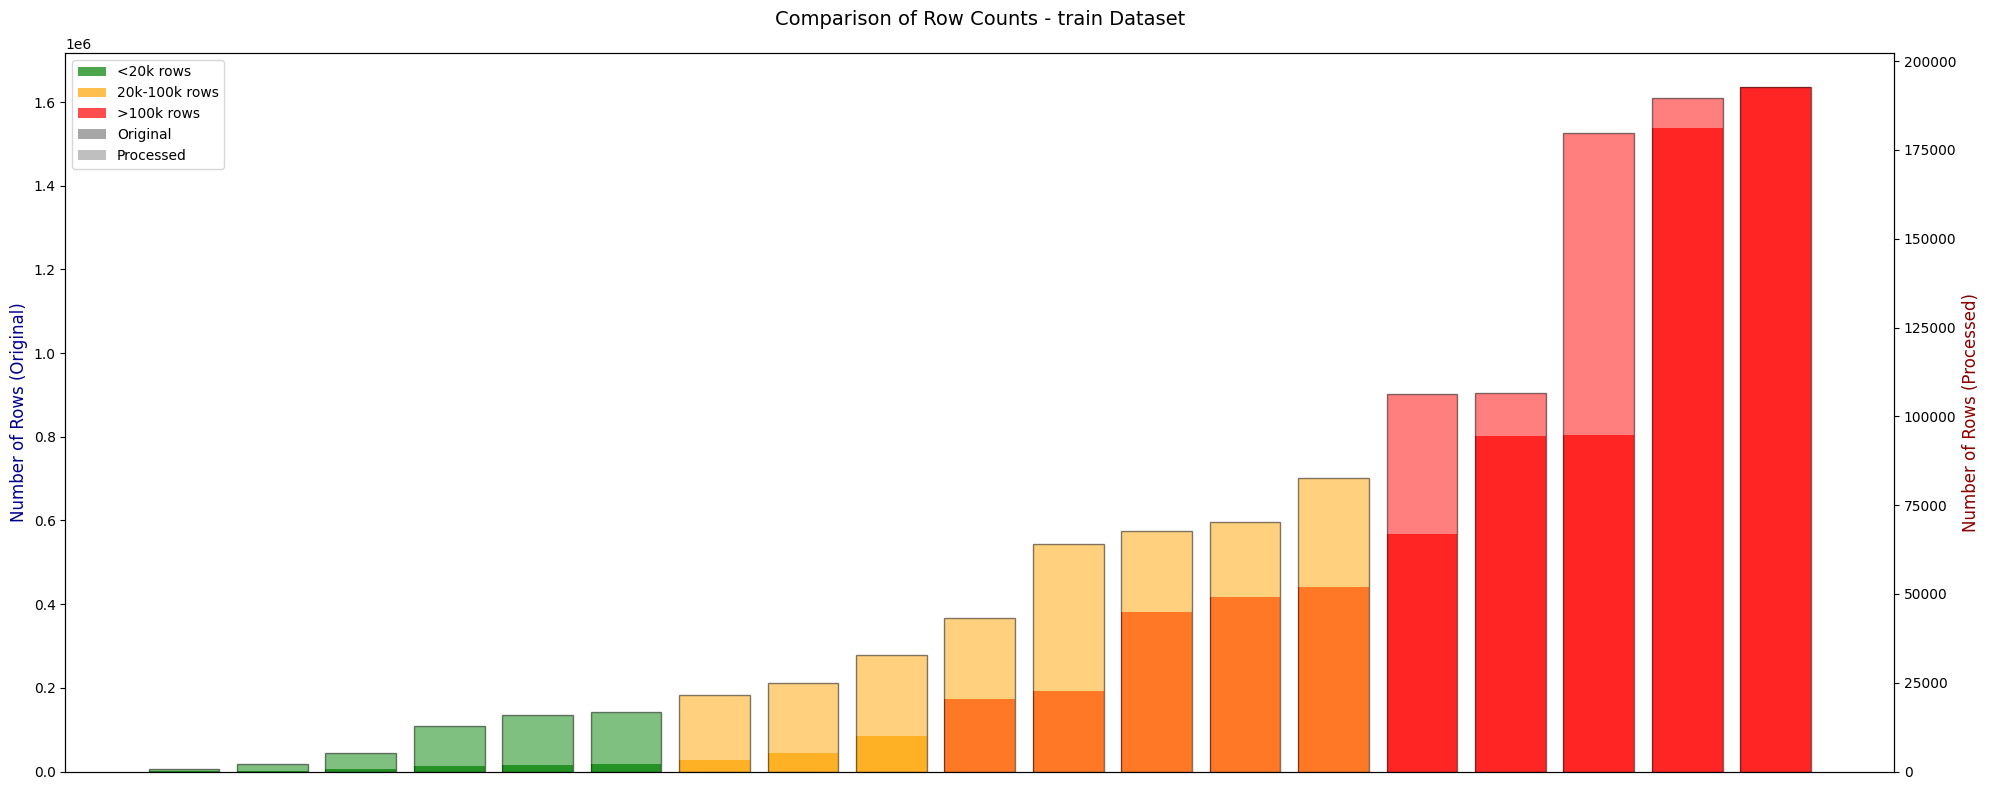

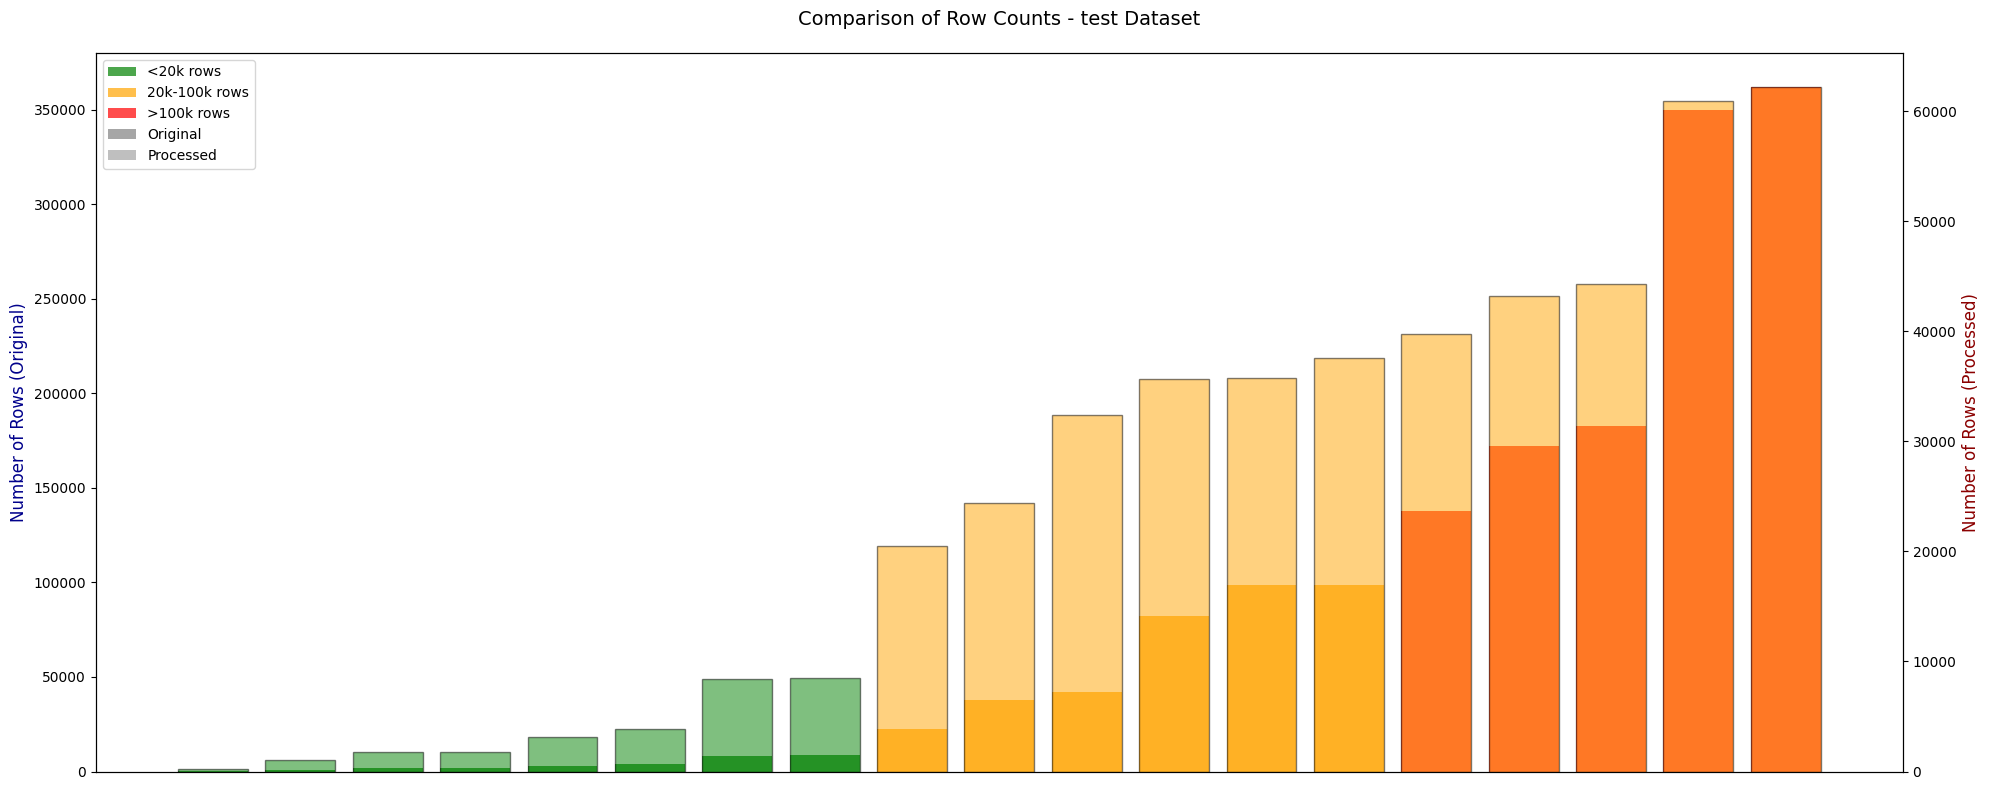

In [66]:
plot_comparison("train")
plot_comparison("test")

### Data Merging and Additional Feature Creation
After creating subsets, we merged the files into consolidated train and test datasets, adding two categorical features:
- `category`: Attack classification (DDoS, DoS, etc.)
- `attack`: Specific attack type 

The mapping between filenames and attack types was automated using regex pattern matching. This consolidation maintains attack classification information while simplifying subsequent analysis.

In [10]:
ATTACK_MAPPING: Dict[str, Tuple[int, str, str]] = {
    r'^Benign': (1, 'BENIGN', 'Benign'),
    r'^ARP_Spoofing': (0, 'SPOOFING', 'ARP Spoofing'),
    r'^Recon-Ping_Sweep': (0, 'RECON', 'Ping Sweep'),
    r'^Recon-VulScan': (0, 'RECON', 'Recon VulScan'),
    r'^Recon-OS_Scan': (0, 'RECON', 'OS Scan'),
    r'^Recon-Port_Scan': (0, 'RECON', 'Port Scan'),
    r'^MQTT-Malformed_Data': (0, 'MQTT', 'Malformed Data'),
    r'^MQTT-DoS-Connect_Flood': (0, 'MQTT', 'DoS Connect Flood'),
    r'^MQTT-DDoS-Publish_Flood': (0, 'MQTT', 'DDoS Publish Flood'),
    r'^MQTT-DoS-Publish_Flood': (0, 'MQTT', 'DoS Publish Flood'),
    r'^MQTT-DDoS-Connect_Flood': (0, 'MQTT', 'DDoS Connect Flood'),
    r'TCP_IP-DoS-TCP': (0, 'DoS', 'DoS TCP'),
    r'TCP_IP-DoS-ICMP': (0, 'DoS', 'DoS ICMP'),
    r'TCP_IP-DoS-SYN': (0, 'DoS', 'DoS SYN'),
    r'TCP_IP-DoS-UDP': (0, 'DoS', 'DoS UDP'),
    r'TCP_IP-DDoS-SYN': (0, 'DDoS', 'DDoS SYN'),
    r'TCP_IP-DDoS-TCP': (0, 'DDoS', 'DDoS TCP'),
    r'TCP_IP-DDoS-ICMP': (0, 'DDoS', 'DDoS ICMP'),
    r'TCP_IP-DDoS-UDP': (0, 'DDoS', 'DDoS UDP')
}

def get_category_and_attack(filename: str) -> Tuple[int, str, str]:
    """Get category and attack type from filename."""
    for pattern, (is_benign, category, attack) in ATTACK_MAPPING.items():
        if re.match(pattern, filename):
            return is_benign, category, attack
    return -1, 'UNKNOWN', 'UNKNOWN'

In [11]:

def process_files_in_chunks(directory: str, output_file: str, chunk_size: int = 100000) -> None:
    """Process CSV files in chunks and write directly to output file."""
    files = [f for f in os.listdir(directory) if f.endswith('.csv')]
    print(f"Found {len(files)} CSV files in {directory}")
    
    # Write header first
    first_file = True
    
    for filename in files:
        filepath = os.path.join(directory, filename)
        is_benign, category, attack = get_category_and_attack(filename)
        
        # Process the file in chunks
        for chunk in pd.read_csv(filepath, chunksize=chunk_size):
            chunk['is_benign'] = is_benign
            chunk['category'] = category
            chunk['attack'] = attack
            
            # Write to output file
            chunk.to_csv(output_file, 
                        mode='w' if first_file else 'a',
                        header=first_file,
                        index=False)
            first_file = False

In [13]:
base_dir = 'dataset/subset'
for dataset in ['train', 'test']:
    output_file = f'dataset/{dataset}_labeled.csv'
    
    # Process files
    process_files_in_chunks(
        directory=os.path.join(base_dir, dataset),
        output_file=output_file,
        chunk_size=100000
    )

Found 19 CSV files in dataset/subset/train

Found 19 CSV files in dataset/subset/test

In [15]:
train_df = pd.read_csv('dataset/train_labeled.csv')
test_df = pd.read_csv('dataset/test_labeled.csv')

# Get counts
train_categories = train_df['category'].value_counts()
test_categories = test_df['category'].value_counts()
train_attacks = train_df['attack'].value_counts()
test_attacks = test_df['attack'].value_counts()

# Create comparative tables
def create_comparison_table(train_counts, test_counts):
    """Create a comparison table with train and test counts."""
    # Get all unique indices
    all_indices = sorted(set(train_counts.index) | set(test_counts.index))
    
    # Create table rows
    table = [
        [
            index,
            f"{train_counts.get(index, 0):,}",
            f"{test_counts.get(index, 0):,}"
        ]
        for index in all_indices
    ]
    
    # Sort by total count (train + test)
    table.sort(key=lambda x: (
        float(x[1].replace(',', '')) + float(x[2].replace(',', ''))
    ), reverse=True)
    
    return table

# Print total rows
print(f"\nTotal Rows:")
print(f"Train: {len(train_df):,}")
print(f"Test:  {len(test_df):,}")

# Print category distribution
print("\nCategory Distribution:")
category_table = create_comparison_table(train_categories, test_categories)
print(tabulate(
    category_table,
    headers=['Category', 'Train Count', 'Test Count'],
    tablefmt='psql'
))

# Print attack distribution
print("\nAttack Type Distribution:")
attack_table = create_comparison_table(train_attacks, test_attacks)
print(tabulate(
    attack_table,
    headers=['Attack Type', 'Train Count', 'Test Count'],
    tablefmt='psql'
))

Total Rows:

Train: 1,235,465

Test:  465,367

Category Distribution:

+------------+---------------+--------------+
| Category   | Train Count   | Test Count   |
|------------+---------------+--------------|
| DDoS       | 581,986       | 210,677      |
| DoS        | 284,552       | 143,579      |
| BENIGN     | 192,732       | 37,607       |
| MQTT       | 107,607       | 46,182       |
| RECON      | 52,541        | 25,578       |
| SPOOFING   | 16,047        | 1,744        |
+------------+---------------+--------------+

Attack Type Distribution:

+--------------------+---------------+--------------+
| Attack Type        | Train Count   | Test Count   |
|--------------------+---------------+--------------|
| DDoS UDP           | 189,596       | 62,207       |
| DDoS ICMP          | 179,748       | 60,970       |
| Benign             | 192,732       | 37,607       |
| DDoS TCP           | 106,446       | 44,260       |
| DDoS SYN           | 106,196       | 43,240       |
| DoS UDP            | 82,695        | 39,755       |
| DoS SYN            | 70,190        | 35,719       |
| DoS ICMP           | 67,629        | 35,686       |
| DoS TCP            | 64,038        | 32,419       |
| DDoS Connect Flood | 43,304        | 24,383       |
| Port Scan          | 32,796        | 20,524       |
| DoS Publish Flood  | 24,875        | 8,505        |
| DDoS Publish Flood | 21,525        | 8,416        |
| OS Scan            | 16,832        | 3,834        |
| ARP Spoofing       | 16,047        | 1,744        |
| DoS Connect Flood  | 12,773        | 3,131        |
| Malformed Data     | 5,130         | 1,747        |
| Recon VulScan      | 2,173         | 1,034        |
| Ping Sweep         | 740           | 186          |
+--------------------+---------------+--------------+

## ANALYSING FEATURES

In [2]:
# Load the merged dataset
df = pd.read_csv('dataset/train_labeled.csv')

In [3]:
# Print type and count of features
type_counts = df.dtypes.value_counts()
print(tabulate(pd.DataFrame({'Type': type_counts.index, 'Count': type_counts.values}), headers='keys', tablefmt='psql'))

+----+---------+---------+
|    | Type    |   Count |
|----+---------+---------|
|  0 | float64 |      45 |
|  1 | object  |       2 |
|  2 | int64   |       1 |
+----+---------+---------+

We can observe that all features are float, except those we created to label the entries.

### Statistical Analysis

The following code performs statistical analysis on the merged dataset to uncover feature relationships and characteristics. Through correlation matrices, variance metrics, and zero/missing value analysis, it reveals redundant features and quality issues that inform feature selection and preprocessing decisions.

In [14]:
def analyze_features(df: pd.DataFrame) -> Dict[str, pd.DataFrame]:
    # Correlation Analysis
    corr = df.corr(method = 'pearson')
    
    # Feature Variance
    variance = df.var().sort_values(ascending=False)
    
    # Zero Values Percentage
    zero_percent = (df == 0).sum() / len(df) * 100
    
    # Create visualizations
    plt.figure(figsize=(15, 10))
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap="viridis", center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},
           xticklabels=True, yticklabels=True)
    plt.title('Feature Correlation Matrix ')
    plt.tight_layout()
    plt.savefig('img/correlation.png', bbox_inches='tight')
    plt.show()
    
    # Return analysis results
    analysis = {
        'correlation': corr,
        'variance': variance,
        'zero_percentage': zero_percent,
    }
    return analysis

In [6]:
def print_results(analysis_results)-> None:
    # Print variance
    print("\n--- Top 10 High Variance Features ---")
    variance_data = [[feature, value] for feature, value in 
                    analysis_results['variance'].head(10).items()]
    print(tabulate(variance_data, 
                headers=["Feature", "Variance"], 
                tablefmt="grid",
                floatfmt=".5f"))

    # Print correlations
    print("\n--- Features with >90% correlation ---")
    corr_matrix = analysis_results['correlation']
    high_corr = np.where(np.abs(corr_matrix) >= 0.9)
    high_corr_data = []
    for i, j in zip(*high_corr):
        if i < j:  # avoid duplicate pairs
            high_corr_data.append([
                corr_matrix.index[i], 
                corr_matrix.columns[j], 
                corr_matrix.iloc[i, j]
            ])
    print(tabulate(high_corr_data, 
                headers=["Feature 1", "Feature 2", "Correlation"], 
                tablefmt="grid",
                floatfmt=".5f"))

    # Print features with high zero percentage
    print("\n--- Top 10 Zero Value Percentages ---")
    zero_data = [[feature, value] for feature, value in 
                analysis_results['zero_percentage'].sort_values(ascending=False).head(10).items()]
    print(tabulate(zero_data, 
                headers=["Feature", "Zero %"], 
                tablefmt="grid",
                floatfmt=".5f"))

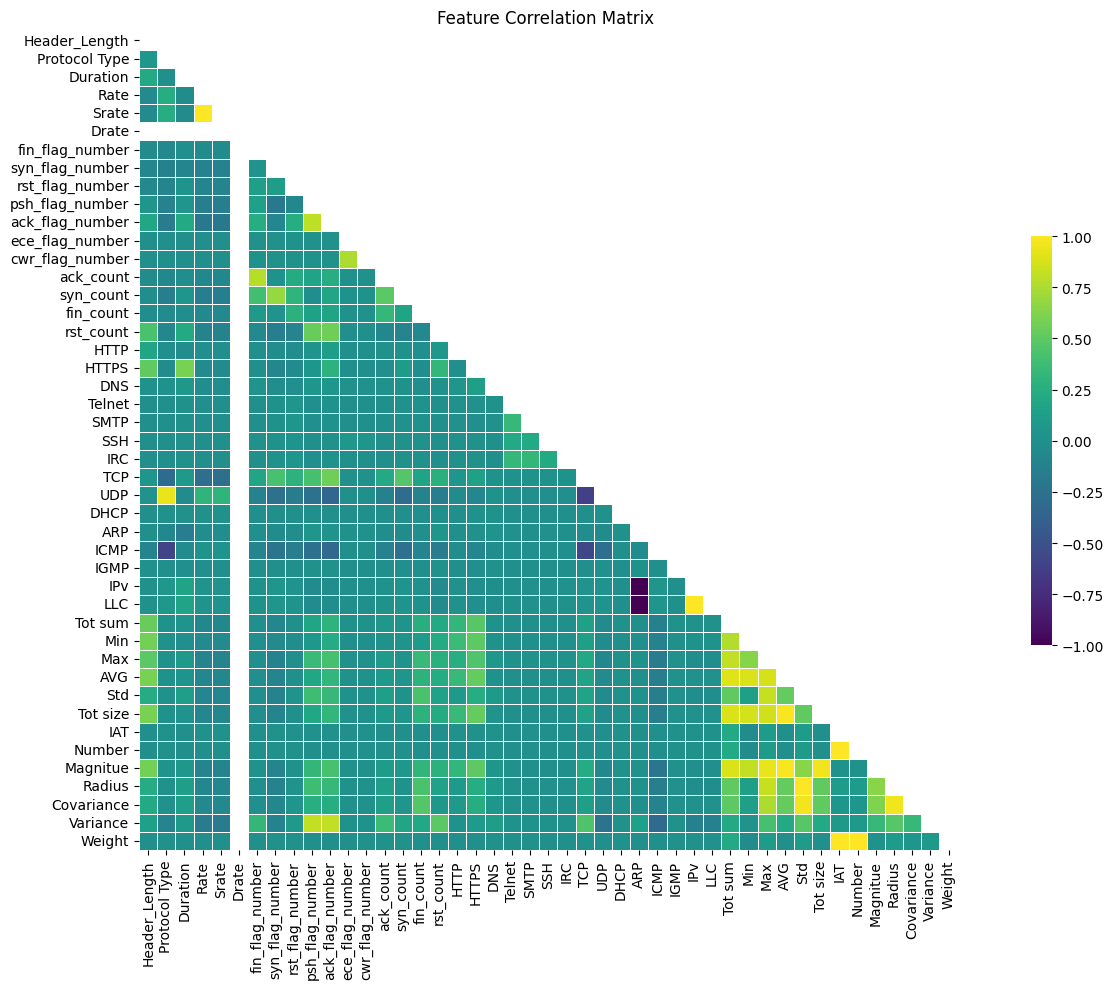

--- Top 10 High Variance Features ---

+---------------+------------------------+
| Feature       |               Variance |
+===============+========================+
| IAT           | 1549430288473305.50000 |
+---------------+------------------------+
| Header_Length |     405163247047.84326 |
+---------------+------------------------+
| Covariance    |       1661613522.03017 |
+---------------+------------------------+
| Rate          |       1184486497.74580 |
+---------------+------------------------+
| Srate         |       1184486497.74580 |
+---------------+------------------------+
| Tot sum       |          4515470.98096 |
+---------------+------------------------+
| rst_count     |          1378643.36662 |
+---------------+------------------------+
| Max           |            74819.33575 |
+---------------+------------------------+
| AVG           |            34526.89303 |
+---------------+------------------------+
| Tot size      |            34444.82767 |
+---------------+------------------------+

--- Features with >90% correlation ---

+---------------+-------------+---------------+
| Feature 1     | Feature 2   |   Correlation |
+===============+=============+===============+
| Protocol Type | UDP         |       0.93743 |
+---------------+-------------+---------------+
| Rate          | Srate       |       1.00000 |
+---------------+-------------+---------------+
| ARP           | IPv         |      -1.00000 |
+---------------+-------------+---------------+
| ARP           | LLC         |      -1.00000 |
+---------------+-------------+---------------+
| IPv           | LLC         |       1.00000 |
+---------------+-------------+---------------+
| Tot sum       | AVG         |       0.90486 |
+---------------+-------------+---------------+
| Max           | Magnitue    |       0.93075 |
+---------------+-------------+---------------+
| AVG           | Tot size    |       0.97758 |
+---------------+-------------+---------------+
| AVG           | Magnitue    |       0.97987 |
+---------------+-------------+---------------+
| Std           | Radius      |       0.99997 |
+---------------+-------------+---------------+
| Std           | Covariance  |       0.95654 |
+---------------+-------------+---------------+
| Tot size      | Magnitue    |       0.95805 |
+---------------+-------------+---------------+
| IAT           | Number      |       0.99914 |
+---------------+-------------+---------------+
| IAT           | Weight      |       0.99934 |
+---------------+-------------+---------------+
| Number        | Weight      |       0.99994 |
+---------------+-------------+---------------+
| Radius        | Covariance  |       0.95654 |
+---------------+-------------+---------------+

--- Top 10 Zero Value Percentages ---

+-----------------+-----------+
| Feature         |    Zero % |
+=================+===========+
| Drate           | 100.00000 |
+-----------------+-----------+
| DHCP            |  99.99304 |
+-----------------+-----------+
| cwr_flag_number |  99.98972 |
+-----------------+-----------+
| IGMP            |  99.98891 |
+-----------------+-----------+
| ece_flag_number |  99.98640 |
+-----------------+-----------+
| Telnet          |  99.93112 |
+-----------------+-----------+
| SMTP            |  99.93080 |
+-----------------+-----------+
| IRC             |  99.93031 |
+-----------------+-----------+
| SSH             |  99.92845 |
+-----------------+-----------+
| HTTP            |  99.46838 |
+-----------------+-----------+

In [15]:
numeric_df = df.select_dtypes(include=[np.float64])
analysis_results = analyze_features(numeric_df)
print_results(analysis_results)

## FEATURES SELECTION

We can see, both from the correlation matrix and from the percentages of zero values, that Drate column is empty: we dropped it.

In [4]:
df=df.drop('Drate', axis=1)

This was the only trivial choice. However, further selection is needed: we can see that there is high correlation within data, and this can negatively affect the quality of our models. For this reason, we want to keep only non-redundant features to maximise the discriminatory power of the variables. 

We based our first approach on the simple observation of the output of the previous analysis. Through a combination of correlation and variance, we decided to drop the following columns: 

In [5]:
to_drop = ["Srate", "Protocol Type", "IPv", "LLC", "Tot sum", "Tot size", "AVG", "Max", "Number", "Weight"]
df_sel_manual = df.drop(columns=to_drop)

As a starting point, in order to evaluate our dataset and choices, we setup a first Classification model. We want to predict if a packet flow is benign or malicious using a Random Forest. For this, we created a new boolean column 'is_benign'. Since we have an abundance of data, we splitted the training dataset into Train and Validation sets, to avoid overfitting the test dataset in this feature selection phase.

In [6]:
# Splitting the Dataset in Training and Validation sets
X_train, X_val, y_train, y_val = train_test_split(
    df_sel_manual.drop(['is_benign', 'category', 'attack'], axis=1),
    df_sel_manual['is_benign'], train_size=0.7, random_state=42
)

In [7]:

# Training the RandomForest
rnd_forest = RandomForestClassifier(random_state=42)
rnd_forest.fit(X_train, y_train);

# Saving the model
dump(rnd_forest, 'models/random_forest_sel_man.joblib')

['models/random_forest_sel_man.joblib']

A useful metric that the RandomForest ensemble provides is the Feature Importance (Gini index). This can be used for further refinement of our feature selection.

In [8]:
try:
    rnd_forest
except NameError:
    rnd_forest = load('models/random_forest_sel_man.joblib')

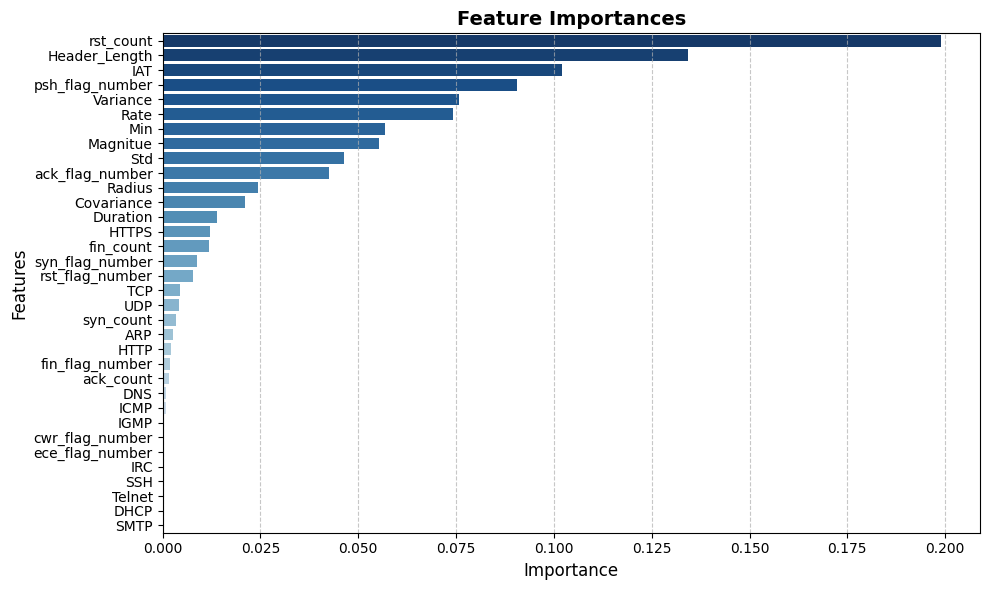

In [9]:
feature_importances_dict = dict(zip(X_train.columns, rnd_forest.feature_importances_))

# Sort features by importance (descending order)
sorted_dict = dict(sorted(feature_importances_dict.items(), key=lambda x: x[1], reverse=True))

# Create plot
plt.figure(figsize=(10, 6))
sns.barplot(
    x=list(sorted_dict.values()),
    y=list(sorted_dict.keys()),
    hue=list(sorted_dict.keys()),  # Add this line
    palette="Blues_r"
)
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.title("Feature Importances", fontsize=14, fontweight="bold")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Evaluating the performance on the validation set, using common metrics:

In [10]:
def evaluate_model(y_true, y_pred, model_name="Model"):
    """
    Print simplified but comprehensive model evaluation metrics.
    
    Parameters:
    -----------
    y_true : array-like
        True labels
    y_pred : array-like
        Predicted labels
    model_name : str, optional
        Name of the model for display purposes
    """
    console = Console()
    
    # Calculate core metrics
    metrics = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, average='weighted'),
        "Recall": recall_score(y_true, y_pred, average='weighted'),
        "F1 Score": f1_score(y_true, y_pred, average='weighted')
    }
    
    # Create metrics table
    table = Table(show_header=True, header_style="bold white", box=None)
    table.add_column("Metric", style="cyan")
    table.add_column("Score", justify="right")
    
    # Add metrics rows with color coding
    for metric, value in metrics.items():
        color = "green" if value > 0.8 else "yellow" if value > 0.6 else "red"
        table.add_row(
            metric,
            f"[{color}]{value:.5f}[/{color}]"
        )
    
    # Calculate confusion matrix summary
    cm = confusion_matrix(y_true, y_pred)
    
    # Create confusion matrix table
    cm_table = Table(show_header=True, header_style="bold white", box=None)
    cm_table.add_column("Guess \\ OG", style="cyan")
    for i in range(cm.shape[1]):
        cm_table.add_column(f"Class {i}", justify="right")
    
    for i in range(cm.shape[0]):
        row = [f"Class {i}"] + [str(cm[i, j]) for j in range(cm.shape[1])]
        cm_table.add_row(*row)
    
    # Create a combined panel with two columns
    combined_table = Table.grid(expand=True)
    combined_table.add_column(justify="center", ratio=1)
    combined_table.add_column(justify="center", ratio=1)
    
    combined_table.add_row(table, cm_table)
    
    # Create and display panel
    panel = Panel(
        combined_table,
        title=f"[bold]{model_name} - Performance Metrics and Confusion Matrix[/bold]",
        border_style="white"
    )
    
    console.print("\n", panel, "\n")
    return metrics

In [11]:
y_pred = rnd_forest.predict(X_val)
with open('models/random_forest_sel_man.json', 'w') as f:
    json.dump(evaluate_model(y_val, y_pred, model_name="Random Forest"), f)

╭─────────────────────────── Random Forest - Performance Metrics and Confusion Matrix ────────────────────────────╮
│  Metric       Score                                      Guess \ OG  Class 0  Class 1                           │
│  Accuracy   0.99661                                      Class 0      312035      941                           │
│  Precision  0.99664                                      Class 1         315    57349                           │
│  Recall     0.99661                                                                                             │
│  F1 Score   0.99662                                                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

The results are good, but now let's try selecting the features with a more robust and reliable approach. This time, beyond the correlation calculation (same as we did before), we compute a Hierarchical Clustering, to group the features which are more correlated. We selected Euclidean distance and complete-linkage.

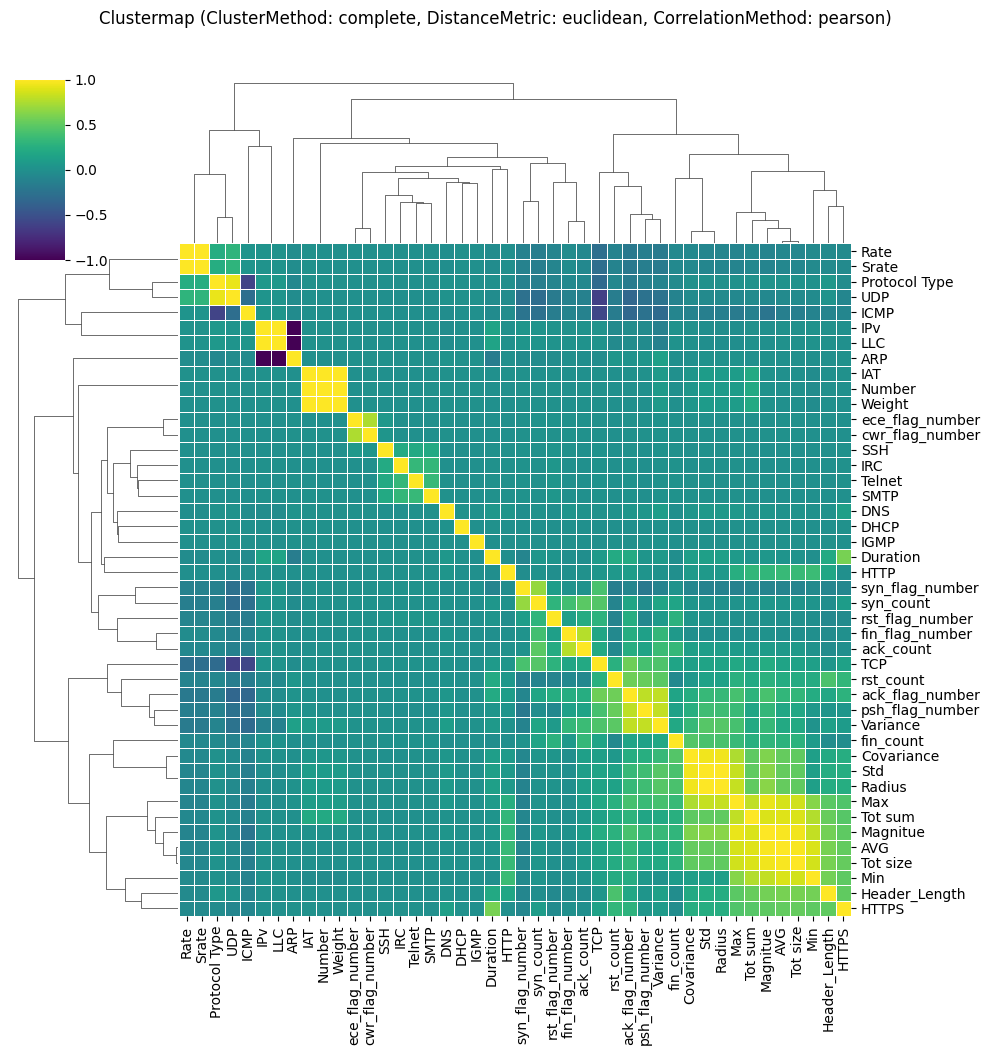

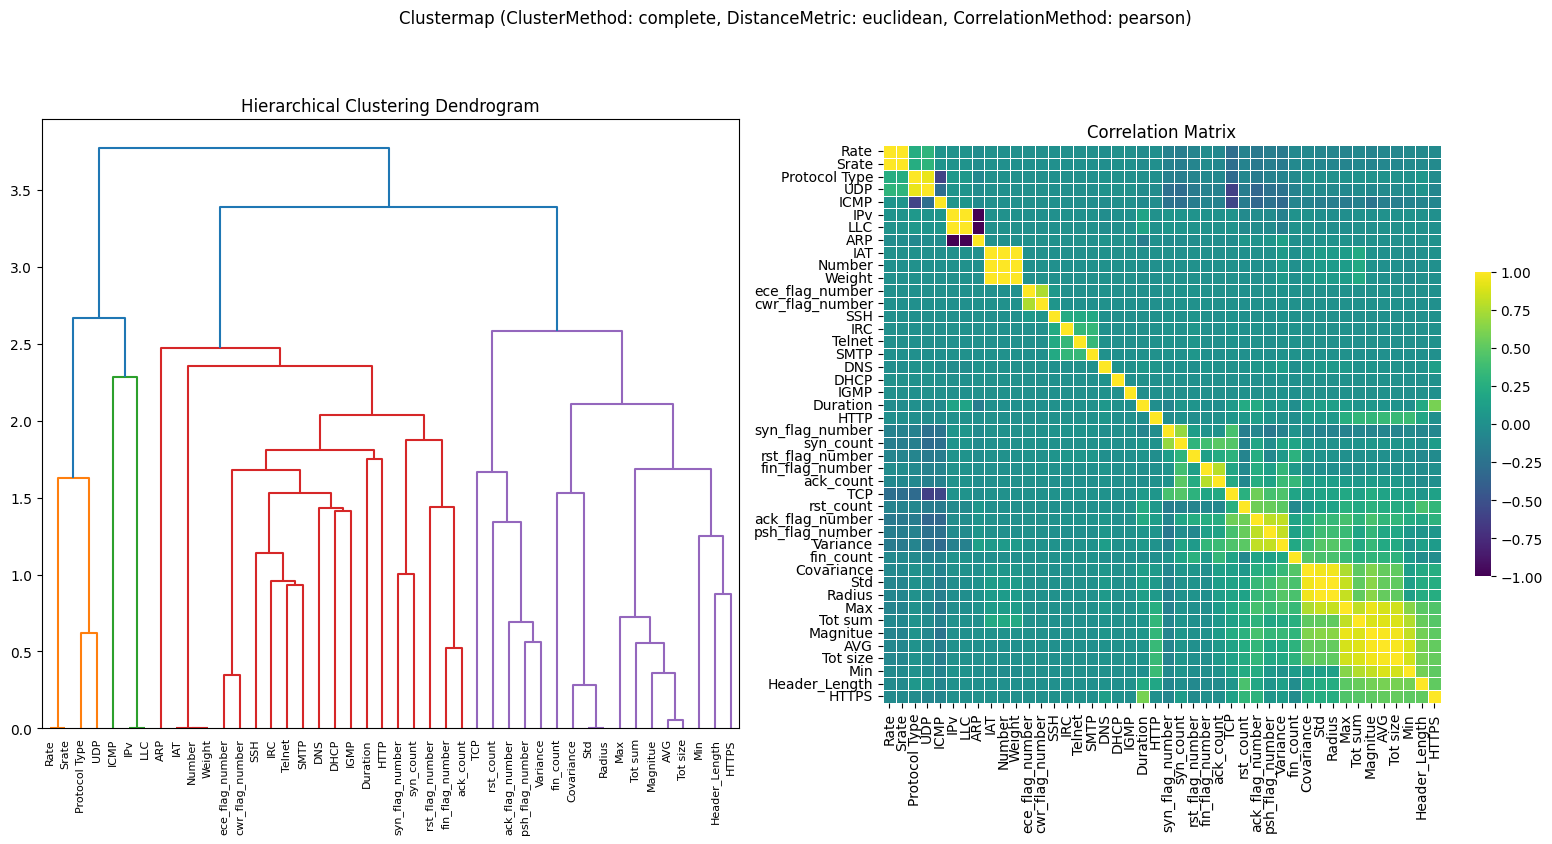

In [12]:
# Parameters
corr_method = 'pearson'
link_method = 'complete'
dist_metric = 'euclidean'

# Compute correlation matrix, excluding categorical columns
corr = df.drop(['is_benign', 'attack', 'category'], axis=1).corr(method=corr_method)

# Create initial clustermap to get linkage matrix
g = sns.clustermap(
    corr,
    annot=False,
    cbar=True,
    cmap="viridis",
    center=0,
    linewidths=.5,
    cbar_kws={"shrink": .5},
    metric=dist_metric,
    method=link_method,
    xticklabels=True,
    yticklabels=True
)
g.figure.suptitle(
    f"Clustermap (ClusterMethod: {link_method}, DistanceMetric: {dist_metric}, CorrelationMethod: {corr_method})",
    y=1.05
)

# Create detailed visualization with dendrogram and correlation matrix
linkage_matrix = g.dendrogram_col.linkage
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Left plot: Dendrogram
dendrogram(
    linkage_matrix,
    ax=ax1,
    labels=corr.columns
)
ax1.set_title("Hierarchical Clustering Dendrogram")

# Right plot: Reordered correlation matrix
dendro_idx = g.dendrogram_col.reordered_ind
reordered_corr = corr.iloc[dendro_idx, dendro_idx]
sns.heatmap(
    reordered_corr,
    annot=False,
    cmap="viridis",
    cbar=True,
    ax=ax2,
    cbar_kws={"shrink": .5},
    linewidths=0.5,
    square=True,
    xticklabels=True,
    yticklabels=True
)
ax2.set_title("Correlation Matrix")

# Final layout adjustments
fig.suptitle(
    f"Clustermap (ClusterMethod: {link_method}, DistanceMetric: {dist_metric}, CorrelationMethod: {corr_method})",
    y=1.05
)
plt.tight_layout()
plt.show()

Our decision in this step is constrained to selecting the distance threshold by visually inspecting the dendrogram. The remaining process is automated by the script, which identifies the feature with the highest importance (based on Gini) for each cluster formed at the chosen threshold.

In [13]:
threshold = 1.0 

# Group features by cluster
clusters = fcluster(linkage_matrix, t=threshold, criterion='distance')
clustered_features = {}
for idx, cluster in enumerate(clusters):
    if cluster not in clustered_features:
        clustered_features[cluster] = []
    clustered_features[cluster].append(corr.columns[idx])

# Print clusters in a clean, sorted format
print("Clustered Features:\n" + "-"*20)
# Sort by cluster number for better readability
for cluster in sorted(clustered_features.keys()):
    features = clustered_features[cluster]
    # Join features with commas and proper spacing
    feature_list = ", ".join(features)
    print(f"Cluster {cluster:2d}: {feature_list}")

Clustered Features:
--------------------

Cluster  1: Rate, Srate

Cluster  2: Protocol Type, UDP

Cluster  3: IPv, LLC

Cluster  4: ICMP

Cluster  5: IAT, Number, Weight

Cluster  6: ece_flag_number, cwr_flag_number

Cluster  7: Telnet, SMTP, IRC

Cluster  8: SSH

Cluster  9: DHCP

Cluster 10: IGMP

Cluster 11: DNS

Cluster 12: Duration

Cluster 13: HTTP

Cluster 14: syn_flag_number

Cluster 15: syn_count

Cluster 16: fin_flag_number, ack_count

Cluster 17: rst_flag_number

Cluster 18: ARP

Cluster 19: psh_flag_number, ack_flag_number, Variance

Cluster 20: rst_count

Cluster 21: TCP

Cluster 22: Std, Radius, Covariance

Cluster 23: fin_count

Cluster 24: Tot sum, Max, AVG, Tot size, Magnitue

Cluster 25: Header_Length, HTTPS

Cluster 26: Min

In [14]:
# Prepare data for Random Forest
X = df.drop(['is_benign', 'category', 'attack'], axis=1)
y = df['is_benign']
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.7, random_state=42)

In [15]:
# Train Random Forest and get feature importances
rnd_forest.fit(X_train, y_train)
feature_importances = dict(zip(X_train.columns, rnd_forest.feature_importances_))

# Sort features by importance
sorted_features = sorted(
    feature_importances.items(), 
    key=lambda x: x[1], 
    reverse=True
)

# Select most important feature from each cluster
selected_features = []
for cluster, features in clustered_features.items():
    # Get importance scores for features in this cluster
    cluster_importances = {
        feature: feature_importances[feature] 
        for feature in features
    }
    # Select feature with highest importance
    best_feature = max(cluster_importances, key=cluster_importances.get)
    selected_features.append(best_feature)

In [16]:
print("\nSelected features from each cluster:")
for feature in selected_features:
    print(f"  - {feature}")

Selected features from each cluster:

- Header_Length

- UDP

- Duration

- Srate

- ack_count

- syn_flag_number

- rst_flag_number

- psh_flag_number

- ece_flag_number

- syn_count

- fin_count

- rst_count

- HTTP

- DNS

- IRC

- SSH

- TCP

- DHCP

- ARP

- ICMP

- IGMP

- LLC

- Magnitue

- Min

- Radius

- IAT

Let's train a new RandomForest with the dataset containing the selected features

In [17]:
selected_features.extend(['is_benign', 'attack', 'category'])
df_sel_hclust = df[selected_features]

X_train, X_val, y_train, y_val = train_test_split(
    df_sel_hclust.drop(['is_benign', 'category', 'attack'], axis=1),
    df_sel_hclust['is_benign'], train_size=0.7, random_state=42
)
rnd_forest.fit(X_train, y_train);

# Save the model
dump(rnd_forest, 'models/random_forest_sel_hclust.joblib');

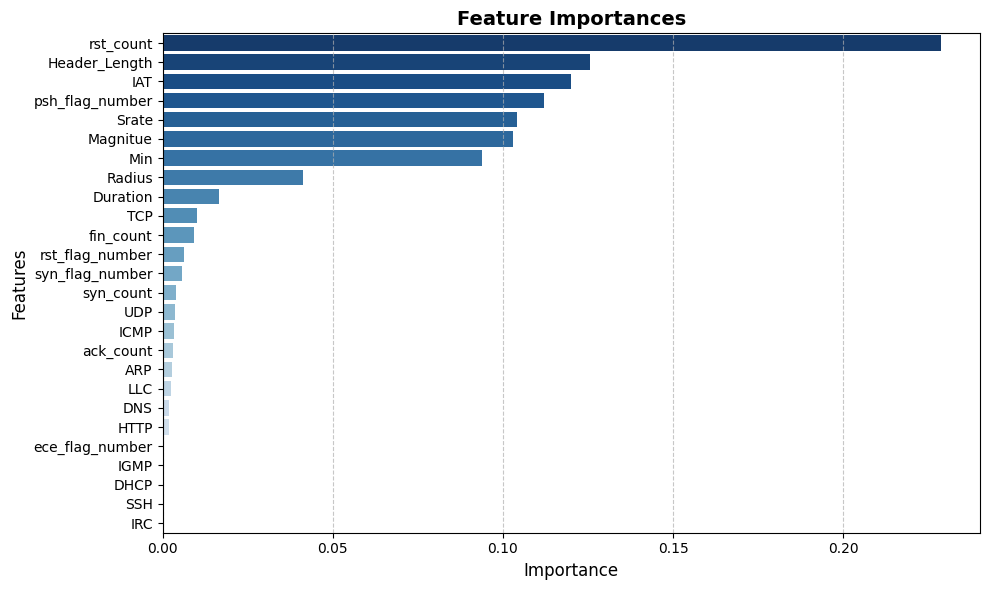

In [18]:
try:
    rnd_forest
except NameError:
    rnd_forest = load('models/random_forest_sel_hclust.joblib')

feature_importances_dict = dict(zip(X_train.columns, rnd_forest.feature_importances_))

# Sort features by importance (descending order)
sorted_dict = dict(sorted(feature_importances_dict.items(), key=lambda x: x[1], reverse=True))

# Create plot
plt.figure(figsize=(10, 6))
sns.barplot(
    x=list(sorted_dict.values()),
    y=list(sorted_dict.keys()),
    hue=list(sorted_dict.keys()),  # Add this line
    palette="Blues_r"
)
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.title("Feature Importances", fontsize=14, fontweight="bold")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Let's test the performance of the new approach used for feature selection.

In [19]:
y_pred = rnd_forest.predict(X_val)
with open('models/random_forest_sel_hclust.json', 'w') as f:
    json.dump(evaluate_model(y_val, y_pred, model_name="Random Forest"), f)

╭─────────────────────────── Random Forest - Performance Metrics and Confusion Matrix ────────────────────────────╮
│  Metric       Score                                      Guess \ OG  Class 0  Class 1                           │
│  Accuracy   0.99661                                      Class 0      312024      952                           │
│  Precision  0.99664                                      Class 1         303    57361                           │
│  Recall     0.99661                                                                                             │
│  F1 Score   0.99662                                                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [21]:
# Load the performance metrics
with open('models/random_forest_sel_hclust.json', 'r') as f:
    metrics_sel_hclust = json.load(f)

# Load the performance metrics
with open('models/random_forest_sel_man.json', 'r') as f:
    metrics_sel_manual = json.load(f)

# Metric names
metric_names = ["Accuracy", "Precision", "Recall", "F1 Score"]

# Combine into a table
table = zip(metric_names, [metrics_sel_hclust[m] for m in metric_names], [metrics_sel_manual[m] for m in metric_names])

# Print the table
print(tabulate(table, headers=["Metric", "HClust Selection", "Manual Selection"], floatfmt=".7f"))

Metric       HClust Selection    Manual Selection
---------  ------------------  ------------------
Accuracy            0.9966140           0.9966113
Precision           0.9966409           0.9966368
Recall              0.9966140           0.9966113
F1 Score            0.9966217           0.9966187

There was an improvement!

Let's save the new dataset with the selected features.

In [22]:
df_sel_hclust.to_csv('dataset/train_sel_hclust.csv', index=False)

## FEATURES VISUALISATION

Let's start to compare the distribution of the attack to the benign data flows.

In [23]:
df_sel = pd.read_csv('dataset/train_sel_hclust.csv')

In [24]:
def plot_distributions(df, feature):
    # Apply Min-Max scaling
    scaler = MinMaxScaler()
    df[feature] = scaler.fit_transform(df[[feature]])
    
    plt.figure(figsize=(12, 6))
    attacks = ['SPOOFING', 'RECON', 'MQTT', 'DoS', 'DDoS']
    for attack in attacks:
        data = df[df['category'].isin([attack, 'BENIGN'])]

        plt.subplot(2, 3, attacks.index(attack) + 1)
        sns.kdeplot(data=data, x=feature, hue='category', hue_order=['BENIGN', attack], fill=True, common_norm=False)
        plt.title(f'BENIGN vs {attack}')
        plt.xlabel(feature)
        #plt.yscale('log')

    plt.tight_layout()
    plt.show()

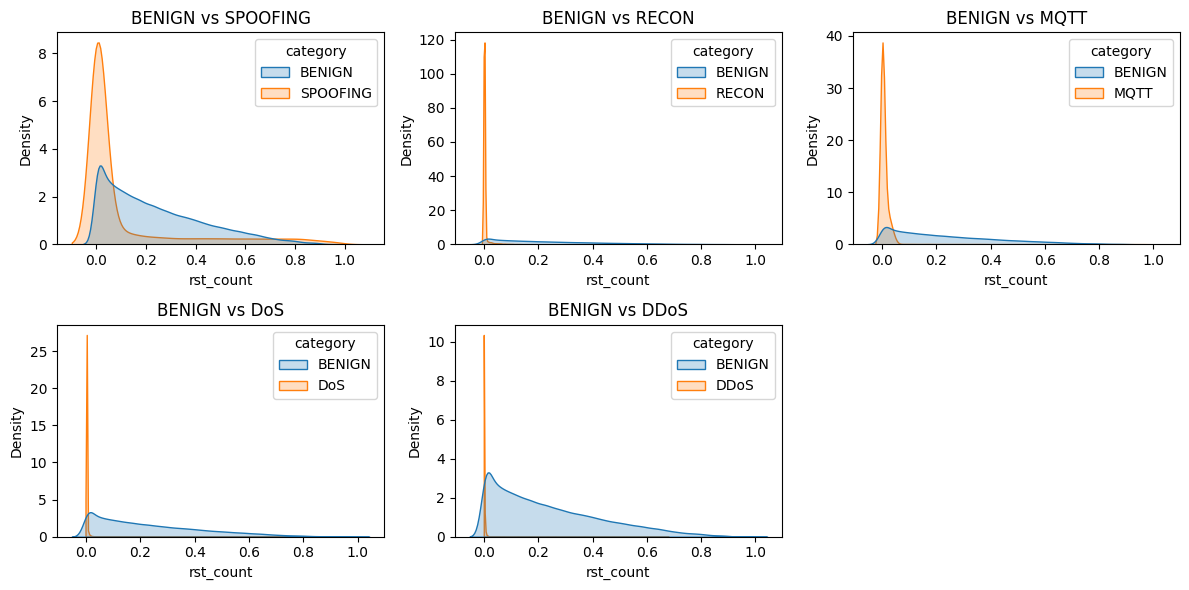

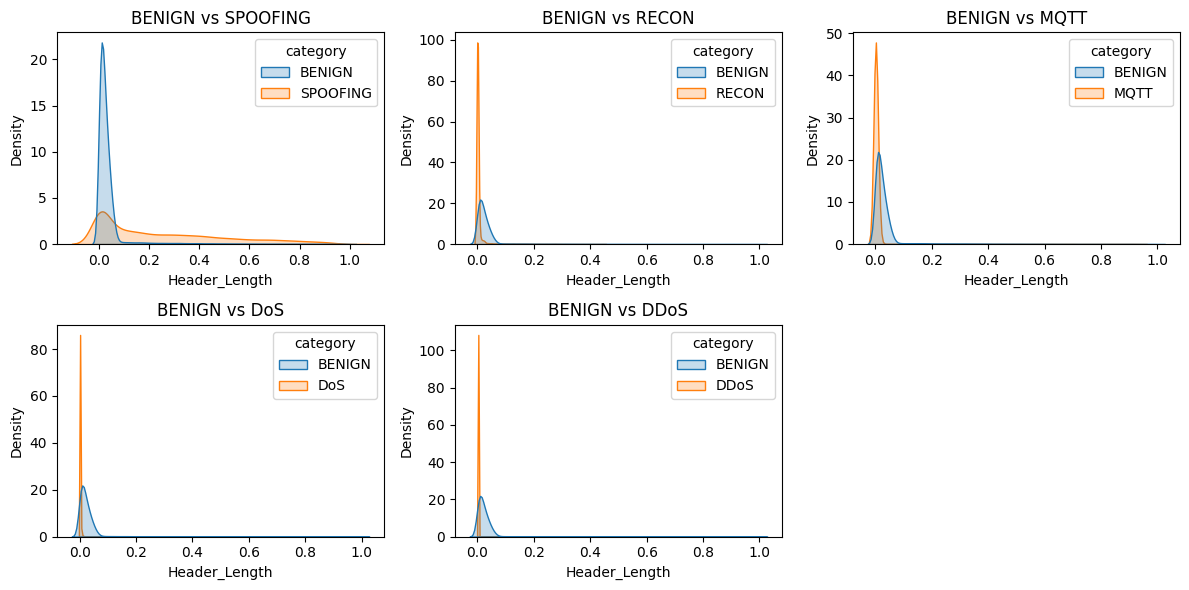

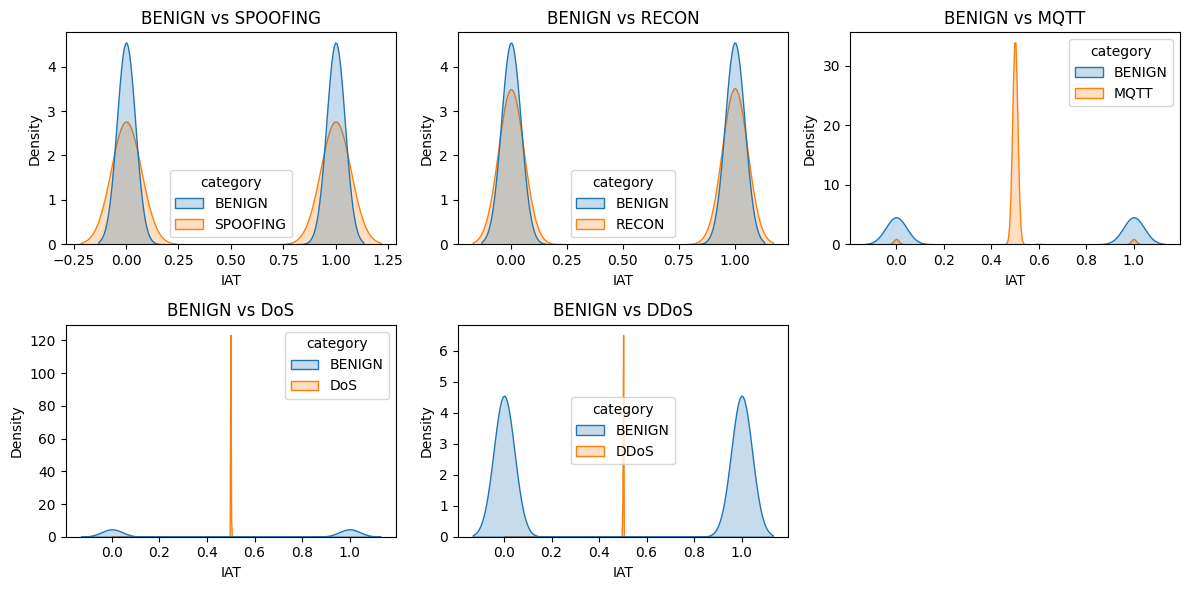

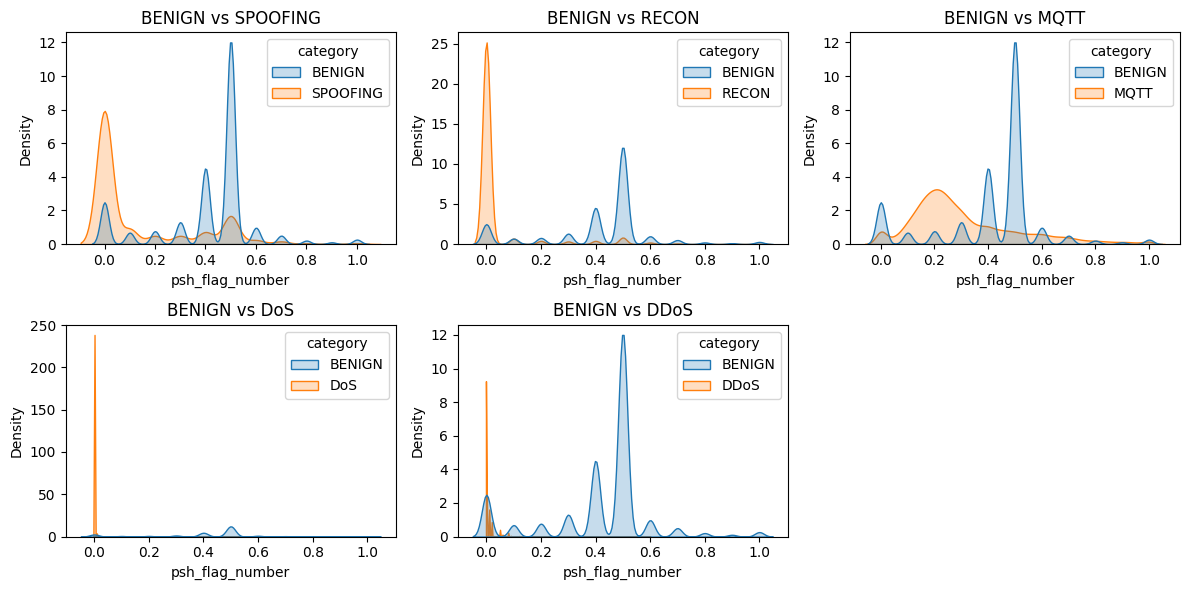

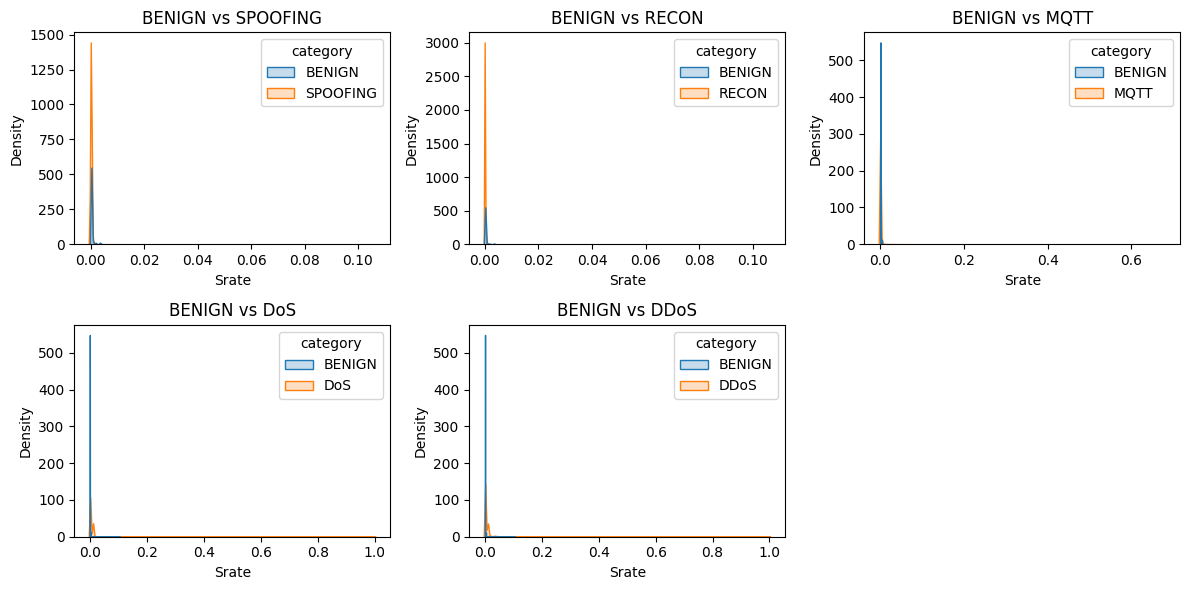

In [30]:
try:
    rnd_forest 
except NameError:
    # Load model if not already loaded
    rnd_forest = load('models/random_forest_sel_hclust.joblib')
    
feature_importances_dict = dict(
    zip(df_sel_hclust.drop(['is_benign', 'category', 'attack'], axis=1)
        , rnd_forest.feature_importances_))

# Sort features by importance and get top 5 feature names
top_5_features = [feature[0] for feature in sorted(
    feature_importances_dict.items(), 
    key=lambda x: x[1], 
    reverse=True
)[:5]]

# Plot distributions for top 5 features
for feature_name in top_5_features:
    plot_distributions(df_sel, feature_name)

## BINARY CLASSIFICATION

### SetUp of dataset for Binary decision

In order to have a balanced dataset for binary decision, we decided to mantain all benign flow and randomly drop entries of malicious samples in order to have the same quantity of data on both sides. 

In [7]:
df = pd.read_csv('dataset/train_sel_hclust.csv')

In [8]:
def balance_dataset(df: pd.DataFrame, target_column: str = 'is_benign') -> pd.DataFrame:
    # Separate the dataset into two groups
    df_ones = df[df[target_column] == 1]
    df_zeros = df[df[target_column] == 0]
    
    # Determine the number of samples to keep from the zeros group
    num_ones = len(df_ones)
    df_zeros_balanced = df_zeros.sample(n=num_ones, random_state=42)
    
    # Concatenate the balanced zeros with the ones
    df_balanced = pd.concat([df_ones, df_zeros_balanced], ignore_index=True)
    
    # Shuffle the dataset
    df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
    
    return df_balanced

In [9]:
# Balance the dataset
df_balanced = balance_dataset(df)

# Save the balanced dataset
df_balanced.to_csv('dataset/train_binary.csv', index=False)

# Display the distribution of the target column
print(df_balanced['is_benign'].value_counts())

is_benign
0    192732
1    192732
Name: count, dtype: int64